### Import Library

In [189]:
import os
import tqdm
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from IPython.display import clear_output
import torchvision.transforms as transforms

import numpy as np


### DataLoader

In [190]:
class Data_downloader():
    def __init__(self, path_name, transform, batch_size) -> None:
        self.path_name = path_name
        self.transform = transform
        self.batch_size = batch_size

    def download_data(self):
        os.makedirs(self.path_name, exist_ok=True)
        dataset = datasets.MNIST(
            self.path_name, download=True, transform=self.transform
            )
        dataloader = DataLoader(
            dataset=dataset, batch_size=batch_size, shuffle=True
            )
        return dataloader

### Generator

In [191]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim, model_num):
        super().__init__()
        self.model_num = model_num
        self.gen_0 = nn.Sequential(
            nn.Linear(in_features=z_dim, out_features=256),
            nn.LeakyReLU(0.1),
            # in MNIST img_dim = 28*28*1 = 784
            nn.Linear(in_features=256, out_features=img_dim),
            # output should between -1 and 1
            nn.Tanh(),
        )
    def forward(self, x):
        return self.gen_0(x)

### Discriminator

In [192]:
class Discriminator(nn.Module):
    def __init__(self, img_dim, model_num):
        super().__init__()
        self.model_num = model_num
        self.dis_0 = nn.Sequential(
            nn.Linear(in_features=img_dim, out_features=128),
            nn.LeakyReLU(0.1),
            # the out_features is 1 because we only need to output
            # single value, ex: fake is 0, real is 1
            nn.Linear(in_features=128, out_features=1), 
            nn.Sigmoid(),
        )
    def forward(self, x):
        return self.dis_0(x)

### Plot training loss 

In [194]:
def plot_loss(model_name, **kwargs):
    # fix image size
    fig = plt.figure(figsize=(10, 6))
    plt.title(f"{model_name}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    # plot loss
    for label, data in kwargs.items():
        plt.plot(
            range(1, len(data)+1), data,
            label=label
        )
    # plot legend box
    plt.legend(
        loc='lower right',
        fancybox=True, shadow=True
    )

    plt.show()
    
    return fig

### Training

In [195]:
def GAN_training(data_load, model, opts): 
    progress = tqdm.tqdm(total=opts['epochs'])
    loss_all = {'G_loss': [], 'D_loss':[]}
    for epoch in range(1, opts['epochs']+1):
        for batch_idx, (img, label) in enumerate(data_load):
            # 32*1*28*28 to 32*784
            img = img.view(-1, 784).to(opts['device'])
            # 高斯distribution 32*64
            noise = torch.randn((opts['batch_size'], opts['z_dim'])).to(opts['device'])
            # Train Discriminator: max(E log(D(img)) + E log(1-D(G(z))))
            # G(z)
            fake_img = model['G'](noise)
            # D(img), D(G(z))
            D_real_img = model['D'](img).view(-1)
            D_fake_img = model['D'](fake_img).view(-1)
            # log(D(img)), log(1-D(G(z)))
            loss_D_real = opts['criterion'](D_real_img, torch.ones_like(D_real_img))
            loss_D_fake = opts['criterion'](D_fake_img, torch.zeros_like(D_fake_img))
            loss_D = loss_D_real + loss_D_fake

            model['D'].zero_grad()
            loss_D.backward(retain_graph=True)
            model['optim_D'].step()
            
            # Train Generator max(log(D(G(z)))
            output = model['D'](fake_img).view(-1)
            loss_G = opts['criterion'](output, torch.ones_like(output))

            model['G'].zero_grad()
            loss_G.backward()
            model['optim_G'].step()
            
            if batch_idx == len(data_load) - 1:
                print(f"Epoch: [{epoch}/{epochs}], G_Loss: [{loss_G: .4f}], D_Loss: [{loss_D: .4f}]")
                with torch.no_grad():
                    loss_all['G_loss'] += [loss_G.cpu().data.numpy()]
                    loss_all['D_loss'] += [loss_D.cpu().data.numpy()]
                    clear_output(wait=True)
                    plot_loss(opts['model_name'], **loss_all)
                    progress.update(1)
        

### Main Function

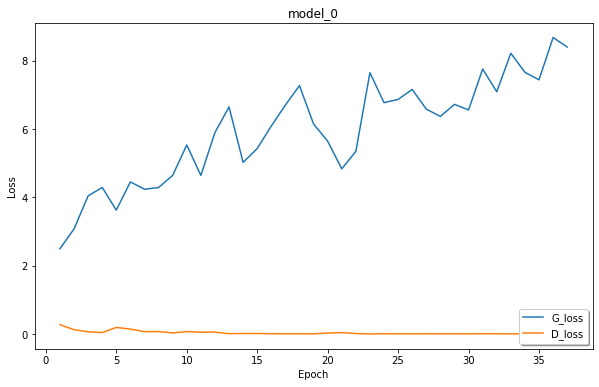

KeyboardInterrupt: 

In [196]:
if __name__ == '__main__':
    # Hyperparameters of our GANs
    hyper_param = {'model_0': {}, 'model_1':{}, 'model_2':{}}
    for idx in range(3):
        hyper_param['model_'+str(idx)] = {
            'lr': 3e-4,
            'z_dim': 64,
            'epochs': 50,
            'batch_size': 32,
            'img_dim': 28 * 28 * 1,
            'model_name': 'model_0',
            'criterion': nn.BCELoss(),
            'device': "cuda" if torch.cuda.is_available() else "cpu"
        }

    model_var = {'model_0': {}, 'model_1':{}, 'model_2':{}}
    # model variable
    for model in model_var:
        param = hyper_param[model]
        G = Generator(param['z_dim'], param['img_dim'], 0).to(param['device'])
        D = Discriminator(param['img_dim'], 0).to(param['device'])
        optim_G = optim.Adam(G.parameters(), lr=param['lr'])
        optim_D = optim.Adam(D.parameters(), lr=param['lr'])
        fixed_noise = torch.randn((param['batch_size'], param['z_dim'])).to(param['device'])
        model_var[model] = {
            'G': G,
            'D': D,
            'optim_G': optim_G,
            'optim_D': optim_D,
            'fixed_noise': fixed_noise
        }
    
    # 
    transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )

    data_load = Data_downloader("MNIST_dataset", transforms, batch_size).download_data()
    GAN_training(data_load, model_var['model_0'], hyper_param['model_0'])
    
    for model in model_var:
        fake_img = model['G'](model['fixed_noise']).reshape(-1, 1, 28, 28)
        fake_img_grid = torchvision.utils.make_grid(fake_img, normalize=True)
        plt.imshow(fake_img_grid.permute(1, 2, 0).cpu().data.numpy())
        plt.show()
    
    '''
        
    ''' 